In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
import tqdm

from scipy.stats import mode
import scipy.misc
import matplotlib.ticker as plticker

import seaborn as sns

from PIL import Image

import time

Using TensorFlow backend.


In [2]:
data_path = '/media/fred/strawberry/ILSVRC2012_img_train/'
class_dirs = glob.glob(data_path + 'n*')
feature_vis_path = 'feature-vis/class-profiles/'

In [ ]:
class_dirs_image_counts_dict = {}
for class_dir in class_dirs:
#     print(class_dir)
    class_dirs_image_counts_dict[class_dir] = len(glob.glob(class_dir + '/*'))

In [ ]:
# class_dirs_image_counts_dict

In [ ]:
class_dirs_image_counts = [class_dirs_image_counts_dict[x] for x in class_dirs_image_counts_dict]
np.unique(class_dirs_image_counts)

In [ ]:
plt.figure()
plt.hist(class_dirs_image_counts, bins=30)
plt.show()

In [ ]:
class_dirs_image_counts[227]

In [ ]:
class_dirs[227]

In [ ]:
np.sum(class_dirs_image_counts)

In [ ]:
imagenet = {}
with open('imagenet_class_index.json') as f:
    data = json.load(f)
    
for i in data:
    imagenet[i] = {}
    imagenet[i]['id'] = data[i][0]
    imagenet[i]['name'] = data[i][1]
    imagenet[i]['image_count'] = class_dirs_image_counts_dict[data_path + imagenet[i]['id']]

In [ ]:
# imagenet

In [ ]:
[imagenet[x] for x in imagenet if imagenet[x]['id'] == 'n02089078']

get `target_class` mapping for inception v1 to map which class is which softmax output

In [ ]:
with open('imagenet_2012_challenge_label_map_proto_edited.json') as f:
    imagenet_map = json.load(f)

In [ ]:
for c in imagenet:
    imagenet[c]['target_class'] = imagenet_map[imagenet[c]['id']]

In [ ]:
# imagenet

load in data

In [ ]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()

In [ ]:
# googlenet.show_graph()

In [17]:
batch = 3
param_f = lambda: param.image(256, fft=True, decorrelate=True, batch=batch)

transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(list(range(-10,10)) + list(range(-5,5)) + 10*list(range(-2,2))),
    transform.jitter(2)
]

In [3]:
layer = "mixed4e"

In [7]:
picking = 2

In [66]:
for class_id in range(350, 351):
# for class_id in range(1000):
    print('class_id: ', class_id)
    start = time.time()
    image_paths = glob.glob(data_path + imagenet[str(class_id)]['id'] + '/*')
#     image_paths = glob.glob(data_path + 'n07718472' + '/*')
    print('get image paths\n', time.time() - start)

    images = np.zeros((len(image_paths),224,224,3), dtype=np.uint8)
    print('make np array\n', time.time() - start)

    for i, image_path in enumerate(image_paths):
#         if i%500 == 0:
#             print(i)
        img = image.load_img(image_path, target_size=(224, 224))
        image_rgb = image.img_to_array(img)
        images[i] = image_rgb
    print('load and preprocess images from one class\n', time.time() - start)

    with tf.Graph().as_default(), tf.Session():
        img_from_disk = tf.dataset().batch(12).map(preprocess_input)
        t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
        t_input_preprocessed  = tf.map_fn(preprocess_input, t_input)
        T = render.import_model(googlenet, t_input_preprocessed, None)
        acts = T(layer).eval({t_input: images})
    print('tf session and get activations\n', time.time() - start)

    acts_gap = np.zeros((acts.shape[0],acts.shape[-1]))
    for i in range(acts.shape[0]):
#         if i%500 == 0:
#             print(i)
        for j in range(acts[i].shape[-1]):
            acts_gap[i][j] = np.max(acts[i,:,:,j])
    print('max activation channels\n', time.time() - start)


    # METHOD 1: top k
    if picking == 1:
        arg_partition_n = 3
        top_channels = []
        for i in range(acts_gap.shape[0]):
            for channel in list(np.argpartition(acts_gap[i], -arg_partition_n)[-arg_partition_n:]):
                top_channels.append(channel)
            
    # METHOD 2: prob mass
    if picking == 2:
        top_channels = []
        for i in range(acts_gap.shape[0]):
        #     print(i)
            working_acts_gap = acts_gap[i]/np.sum(acts_gap[i])
            prob_mass = 0
            sorted_working_acts_gap, sorted_inds = (list(t) for t in zip(*sorted(zip(working_acts_gap, list(range(working_acts_gap.shape[0]))), reverse=True)))
            j=0
            while prob_mass < 0.01:
                top_channels.append(sorted_inds[j])
                prob_mass += sorted_working_acts_gap[j]
        #         print(len(top_channels))
                j += 1
    print('get top channels\n', time.time() - start)

      
    
#     FEATURE VIS
#     for i in range(arg_partition_n):
# 
#         channel_to_visualize = top_channels_to_save[i]['channel']
#         obj = objectives.channel(layer + "_pre_relu", channel_to_visualize) - 1e2*objectives.diversity(layer)
# 
#         a = render.render_vis(model=googlenet,
#                                         objective_f=obj,
#                                         param_f=param_f,
#                                         thresholds=(1000,),
#                                         transforms=transforms,
#                                         verbose=False)
#         for b in range(batch):
#             im = Image.fromarray(np.uint8(a[0][b]*255))
#             im.save(feature_vis_path + str(channel_to_visualize) + "_" + str(b) + ".png")
    
    
    (values, counts) = np.unique(top_channels, return_counts=True)
    sorted_counts, sorted_values = (list(t) for t in zip(*sorted(zip(counts, values), reverse=True)))
    
    top_channels_to_save = []
    for pair in [list(z) for z in zip([int(x) for x in sorted_counts], [int(x) for x in sorted_values])]:
        top_channels_to_save.append({'count': pair[0], 'channel': pair[1] })

    imagenet[str(class_id)]['topChannels'] = top_channels_to_save
    
    print('processing for saving top channels\n', time.time() - start)

    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
        T = render.import_model(googlenet, t_input, t_input)
        preds = T('softmax2').eval({t_input: images})
    print('get softmax predictions\n', time.time() - start)
        
    accuracies = []
    correct = 0
    for i, act in enumerate(preds):
        accuracy = preds[i][imagenet[str(class_id)]['target_class']]
        if np.argmax(preds[i]) == imagenet[str(class_id)]['target_class']:
            correct += 1
        accuracies.append(accuracy)

    accuracies = np.array(accuracies).tolist()

    imagenet[str(class_id)]['accuracies'] = accuracies
    imagenet[str(class_id)]['accuracy'] = correct/len(accuracies)
        
    imagenet[str(class_id)]['pythonKey'] = class_id
    
    end = time.time() - start
    print(end)
    print('\n')

class_id:  350
get image paths
 0.0028481483459472656
make np array
 0.009860038757324219
load and preprocess images from one class
 11.365361452102661
tf session and get activations
 13.872075319290161
max activation channels
 17.469125270843506
get top channels
 18.10296106338501
processing for saving top channels
 18.103559494018555
get softmax predictions
 20.41464400291443
20.420019388198853




In [35]:
imagenet_to_save = []
for c in imagenet:
    imagenet_to_save.append(imagenet[c])

In [21]:
# with open('class-profiles/data/imagenet-all-' + str(layer) + '-probmass.json', 'w') as outfile:
#     json.dump(imagenet_to_save, outfile)

In [22]:
# imagenet_to_save[9]['topChannels']

## Rewrite with Nilaksh for using imagenet from tf records

In [5]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()

In [6]:
googlenet.layers

[Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
 Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
 Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
 Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
 Layer (belonging to InceptionV1) <head1_bottl

In [7]:
layers = {
'mixed3a': 256,
'mixed3b': 480,
'mixed4a': 508,
'mixed4b': 512,
'mixed4c': 512,
'mixed4d': 528,
'mixed4e': 832,
'mixed5a': 832,
'mixed5b': 1024
}

In [19]:
layer = 'mixed4d'
num_of_classes = 1000
num_of_chanels_in_layer = layers[layer]
prob_mass_threshold = 0.01
batch = 200

In [20]:
def _parse_function(example_proto, image_size=224):
    def _bytes_feature(value):
        return tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(value):
        return tf.train.Feature(
            int64_list=tf.train.Int64List(value=[value]))
    
    feature_set = {
        'image/filename': tf.FixedLenFeature([], tf.string),
        'image/encoded': tf.FixedLenFeature([], tf.string),
        'image/height': tf.FixedLenFeature([], tf.int64),
        'image/width': tf.FixedLenFeature([], tf.int64),
        'image/channels': tf.FixedLenFeature([], tf.int64),
        'image/class/label': tf.FixedLenFeature([], tf.int64),
        'image/class/synset': tf.FixedLenFeature([], tf.string)}
  
    parsed_features = tf.parse_single_example(example_proto, feature_set)
    
    image_id = parsed_features['image/filename']
    
    label = parsed_features['image/class/label']
    
    width = parsed_features['image/width']
    height = parsed_features['image/height']
    channels = parsed_features['image/channels']
    
    synset = parsed_features['image/class/synset']
    
    image = parsed_features['image/encoded']
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, tf.constant([image_size, image_size]))
    
    return image, label, synset


filenames = glob.glob('/media/fred/strawberry/imagenet-tf-records/*') 
# filenames = glob.glob('test-images/imagenet-tf-records/*') 

print(len(filenames))

M = np.zeros([num_of_classes, num_of_chanels_in_layer], dtype=int)

with tf.Graph().as_default():
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(_parse_function)
    dataset = dataset.map(lambda img, lab, syn: (preprocess_input(img), lab, syn))
    dataset = dataset.batch(batch)

    iterator = dataset.make_one_shot_iterator()
    t_preprocessed_images, t_labels, t_synsets = iterator.get_next()

    T = render.import_model(googlenet, t_preprocessed_images, None)
    t_imgs_acts = T(layer)

    progress_counter = 0
    with tf.Session() as sess:
        start = time.time()
        
        try:
            with tqdm.tqdm(total=1281167, unit='imgs') as pbar:
                while(True):
                    progress_counter += 1
                    imgs_acts, labels, synsets = sess.run([t_imgs_acts,t_labels,t_synsets])
                    
                    # no sess.run after this
                    # python code here on out
                    for i in range(imgs_acts.shape[0]):
                        acts_max = np.zeros((imgs_acts.shape[-1]))
                        for j in range(imgs_acts[i].shape[-1]):
                            acts_max[j] = np.max(imgs_acts[i,:,:,j])
                                                
                        # METHOD 2: prob mass
                        top_channels = []
                        working_acts_max = acts_max/np.sum(acts_max)
                        prob_mass = 0
                        sorted_working_acts_max, sorted_inds = (list(t) for t in zip(*sorted(zip(working_acts_max, list(range(working_acts_max.shape[0]))), reverse=True)))
                        k=0
                        while prob_mass < prob_mass_threshold:
                            top_channels.append(sorted_inds[k])
                            prob_mass += sorted_working_acts_max[k]
                            k += 1
                        for top_channel in top_channels:
                            M[labels[i]-1][top_channel] += 1
#                         print(synsets[i], labels[i])
    
                    pbar.update(len(labels))

        except tf.errors.OutOfRangeError:
            pass
        
        end = time.time()
        print(end - start)
        print(progress_counter)
        print(progress_counter*batch)

  0%|          | 0/1281167 [00:00<?, ?imgs/s]

1024


100%|█████████▉| 1281024/1281167 [2:02:48<00:00, 166.39imgs/s]

7368.068179607391
6407
1281400


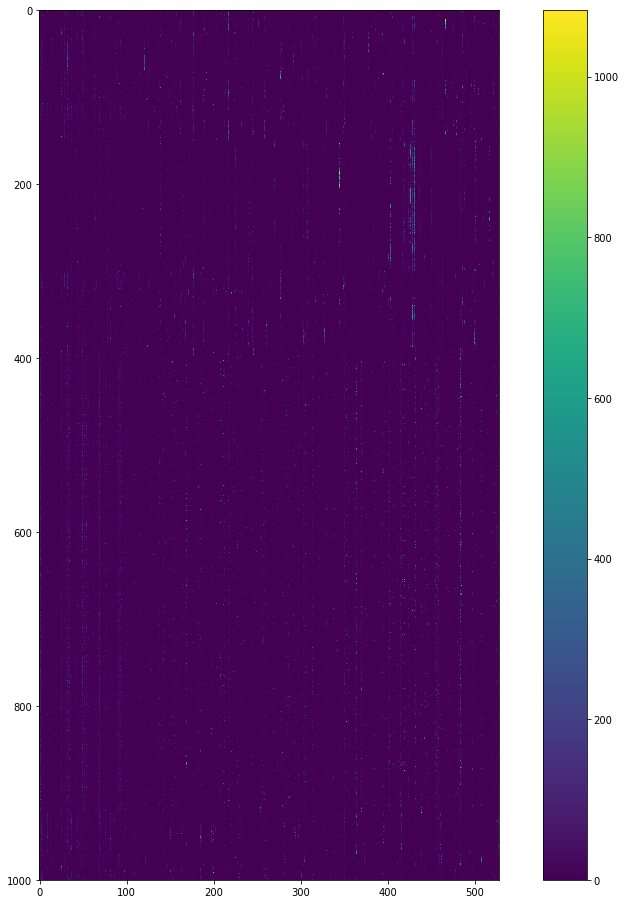

In [21]:
plt.figure(figsize=(16,16))
plt.imshow(M)
plt.colorbar()
plt.show()

In [22]:
np.savetxt('layer-matrices/' + 'M-' + layer + '.csv', M, delimiter=',', fmt='%i')